<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Multi-Risk Derivatives Valuation

A specialty of DX Analytics is the valuation of derivatives instruments defined on multiple risk factors and portfolios composed of such derivatives. This section of the documentation illustrates the usage of the dedicated **multi-risk valuation classes**.

In [1]:
from dx import *
from pylab import plt
plt.style.use('seaborn')

In [2]:
import time
t0 = time.time()

There are the following **multiple risk factor valuation classes** available:

* `valuation_mcs_european_multi` for the valuation of multi-risk derivatives with European exercise
* `valuation_mcs_american_multi` for the valuation of multi-risk derivatives with American exercise

The handling of these classes is similar to building a portfolio of single-risk derivatives positions.

## Market Environments

**Market environments for the risk factors** are the starting point.

In [3]:
r = constant_short_rate('r', 0.06)

In [4]:
me1 = market_environment('me1', dt.datetime(2015, 1, 1))
me2 = market_environment('me2', dt.datetime(2015, 1, 1))

In [5]:
me1.add_constant('initial_value', 36.)
me1.add_constant('volatility', 0.1)  # low volatility
me1.add_constant('currency', 'EUR')
me1.add_constant('model', 'gbm')

In [6]:
me2.add_environment(me1)
me2.add_constant('initial_value', 36.)
me2.add_constant('volatility', 0.5)  # high volatility

We assum a **positive correlation** between the two risk factors.

In [7]:
risk_factors = {'gbm1' : me1, 'gbm2' : me2}
correlations = [['gbm1', 'gbm2', 0.5]]

## Valuation Environment

Similar to the instantiation of a `derivatives_portfolio` object, a **valuation environment** is needed (*unifying certain parameters/assumptions* for all relevant risk factors of a derivative).

In [8]:
val_env = market_environment('val_env', dt.datetime(2015, 1, 1))

In [9]:
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', dt.datetime(2015, 12, 31))
val_env.add_constant('frequency', 'W')
val_env.add_constant('paths', 5000)
val_env.add_curve('discount_curve', r)
val_env.add_constant('maturity', dt.datetime(2015, 12, 31))
val_env.add_constant('currency', 'EUR')

## valuation_mcs_european_multi

As an example for a multi-risk derivative with European exercise consider a **maximum call option**. With multiple risk factors, payoff functions are defined by adding key (the name strings) to the `maturity_value` array object. As with the portfolio valuation class, the multi-risk factor valuation classes get passed `market_environment` objects only and not the risk factor model objects themsemselves.

In [10]:
# European maximum call option
payoff_func = "np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']) - 38, 0)"
vc = valuation_mcs_european_multi(
            name='European maximum call',  # name
            val_env=val_env,  # valuation environment
            risk_factors=risk_factors,  # the relevant risk factors
            correlations=correlations,  # correlations between risk factors
            payoff_func=payoff_func)  # payoff function

In [11]:
vc.risk_factors

{'gbm1': <dx.frame.market_environment at 0x114a74978>,
 'gbm2': <dx.frame.market_environment at 0x114a74940>}

At instantiation, the respective **risk factor model objects** are instantiated as well.

In [12]:
vc.underlying_objects

{'gbm1': <dx.models.geometric_brownian_motion.geometric_brownian_motion at 0x114a6d320>,
 'gbm2': <dx.models.geometric_brownian_motion.geometric_brownian_motion at 0x114a3d358>}

Correlations are stored as well and the resulting **corrleation and Cholesky** matrices are generated.

In [13]:
vc.correlations

[['gbm1', 'gbm2', 0.5]]

In [14]:
vc.correlation_matrix

,gbm1,gbm2
gbm1,1.0,0.5
gbm2,0.5,1.0


In [15]:
vc.val_env.get_list('cholesky_matrix')

array([[1.       , 0.       ],
       [0.5      , 0.8660254]])

The **payoff of a European option** is a one-dimensional `ndarray` object.

In [16]:
np.shape(vc.generate_payoff())

(5000,)

**Present value estimations** are generated by a call of the `present_value` method.

In [17]:
vc.present_value()

7.846

The `update` method allows updating of certain parameters.

In [18]:
vc.update('gbm1', initial_value=50.)

In [19]:
vc.present_value()

16.846

In [20]:
vc.update('gbm2', volatility=0.6)

In [21]:
vc.present_value()

18.144

Let us reset the values to the original parameters.

In [22]:
vc.update('gbm1', initial_value=36., volatility=0.1)
vc.update('gbm2', initial_value=36., volatility=0.5)

When calculating **Greeks** the risk factor, depending on the specific statistic required, now has to be specified by providing its name.

In [23]:
vc.delta('gbm2', interval=0.5)

0.5773

In [24]:
vc.gamma('gbm2')

0.0239

In [25]:
vc.dollar_gamma('gbm2')

15.4872

In [26]:
vc.vega('gbm1')

6.1892

In [27]:
vc.theta()

-5.9229

In [28]:
vc.rho(interval=0.1)

25.6032

In [29]:
val_env.curves['discount_curve'].short_rate

0.06

### Sensitivities Positive Correlation

Almos in complete analogy to the single-risk valuation classes, **sensitivities** can be estimated for the multi-risk valuation classes. 

#### Sensitivities Risk Factor 1

Consider first the case from before with **positive correlation** between the two risk factors. The following estimates and plots the **sensitivities for the first risk factor `gbm1`**.

In [30]:
%%time
s_list = np.arange(28., 46.1, 2.)
pv = []; de = []; ve = []
for s in s_list:
    vc.update('gbm1', initial_value=s)
    pv.append(vc.present_value())
    de.append(vc.delta('gbm1', .5))
    ve.append(vc.vega('gbm1', 0.2))
vc.update('gbm1', initial_value=36.)

CPU times: user 236 ms, sys: 2.73 ms, total: 239 ms
Wall time: 238 ms


In [31]:
%matplotlib inline

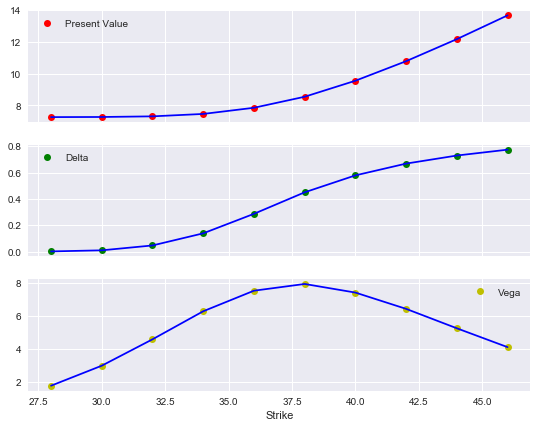

In [32]:
plot_option_stats(s_list, pv, de, ve)

#### Sensitivities Risk Factor 2

Now the **sensitivities for the second risk factor**.

In [33]:
%%time
s_list = np.arange(28., 46.1, 2.)
pv = []; de = []; ve = []
for s in s_list:
    vc.update('gbm2', initial_value=s)
    pv.append(vc.present_value())
    de.append(vc.delta('gbm2', .5))
    ve.append(vc.vega('gbm2', 0.2))

CPU times: user 230 ms, sys: 2.19 ms, total: 232 ms
Wall time: 231 ms


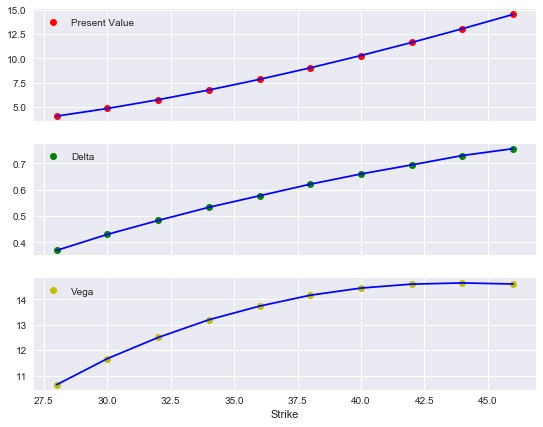

In [34]:
plot_option_stats(s_list, pv, de, ve)

### Sensitivities with Negative Correlation

The second case is for **highly negatively correlated** risk factors.

In [35]:
correlations = [['gbm1', 'gbm2', -0.9]]

In [36]:
# European maximum call option
payoff_func = "np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']) - 38, 0)"
vc = valuation_mcs_european_multi(
            name='European maximum call',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff_func)

#### Sensitivities Risk Factor 1

Again, **sensitivities for the first risk factor** first.

In [37]:
%%time
s_list = np.arange(28., 46.1, 2.)
pv = []; de = []; ve = []
for s in s_list:
    vc.update('gbm1', initial_value=s)
    pv.append(vc.present_value())
    de.append(vc.delta('gbm1', .5))
    ve.append(vc.vega('gbm1', 0.2))
vc.update('gbm1', initial_value=36.)

CPU times: user 239 ms, sys: 2.18 ms, total: 241 ms
Wall time: 240 ms


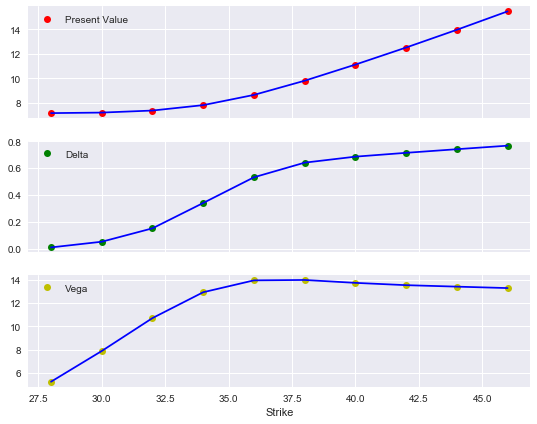

In [38]:
plot_option_stats(s_list, pv, de, ve)

#### Sensitivities Risk Factor 2

Finally, the **sensitivities for the second risk factor** for this second scenario.

In [39]:
%%time
s_list = np.arange(28., 46.1, 2.)
pv = []; de = []; ve = []
for s in s_list:
    vc.update('gbm2', initial_value=s)
    pv.append(vc.present_value())
    de.append(vc.delta('gbm2', .5))
    ve.append(vc.vega('gbm2', 0.2))

CPU times: user 234 ms, sys: 2.21 ms, total: 236 ms
Wall time: 235 ms


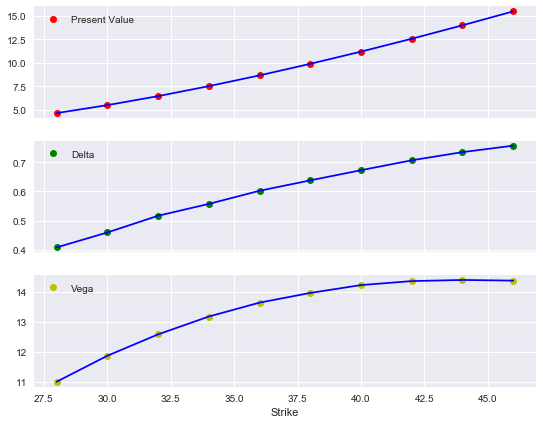

In [40]:
plot_option_stats(s_list, pv, de, ve)

### Surfaces for Positive Correlation Case

Let us return to the case of **positive correlation between the two relevant risk factors**.

In [41]:
correlations = [['gbm1', 'gbm2', 0.5]]

In [42]:
# European maximum call option
payoff_func = "np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']) - 38, 0)"
vc = valuation_mcs_european_multi(
            name='European maximum call',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff_func)

#### Value Surface

We are now interested in the **value surface** of the derivative instrument for both different initial values of the first and second risk factor.

In [43]:
asset_1 = np.arange(28., 46.1, 4.)  # range of initial values
asset_2 = asset_1
a_1, a_2 = np.meshgrid(asset_1, asset_2)
  # two-dimensional grids out of the value vectors
value = np.zeros_like(a_1)

The following estimates for **all possible combinations** of the initial values---given the assumptions from above---the present value of the European maximum call option.

In [44]:
%%time
for i in range(np.shape(value)[0]):
    for j in range(np.shape(value)[1]):
        vc.update('gbm1', initial_value=a_1[i, j])
        vc.update('gbm2', initial_value=a_2[i, j])
        value[i, j] = vc.present_value()

CPU times: user 265 ms, sys: 1.63 ms, total: 267 ms
Wall time: 266 ms


The resulting plot then looks as follows. Here, a helper plot function of DX Analytics is used.

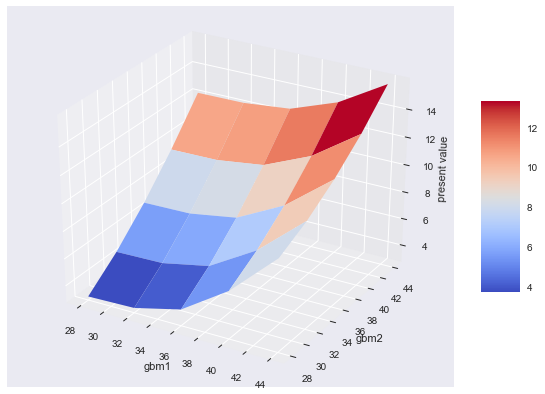

In [45]:
plot_greeks_3d([a_1, a_2, value], ['gbm1', 'gbm2', 'present value'])

#### Delta Surfaces

Applying a very similar approach, a **delta surface** for all possible combinations of the intial values is as easily generated.

In [46]:
delta_1 = np.zeros_like(a_1)
delta_2 = np.zeros_like(a_1)

In [47]:
%%time
for i in range(np.shape(delta_1)[0]):
    for j in range(np.shape(delta_1)[1]):
        vc.update('gbm1', initial_value=a_1[i, j])
        vc.update('gbm2', initial_value=a_2[i, j])
        delta_1[i, j] = vc.delta('gbm1')
        delta_2[i, j] = vc.delta('gbm2')

CPU times: user 757 ms, sys: 2.76 ms, total: 760 ms
Wall time: 760 ms


The plot for the **delta surface of the first risk factor**.

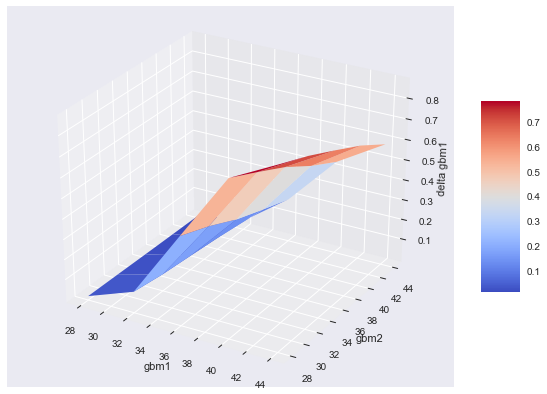

In [48]:
plot_greeks_3d([a_1, a_2, delta_1], ['gbm1', 'gbm2', 'delta gbm1'])

And the plot for the **delta of the second risk factor**.

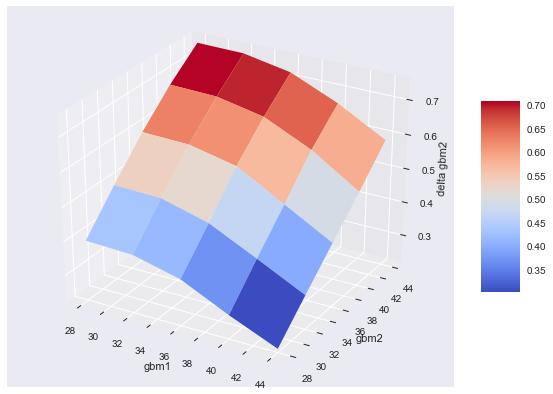

In [49]:
plot_greeks_3d([a_1, a_2, delta_2], ['gbm1', 'gbm2', 'delta gbm2'])

#### Vega Surfaces

The same approach can of course be applied to generate **vega surfaces**.

In [50]:
vega_1 = np.zeros_like(a_1)
vega_2 = np.zeros_like(a_1)

In [51]:
for i in range(np.shape(vega_1)[0]):
    for j in range(np.shape(vega_1)[1]):
        vc.update('gbm1', initial_value=a_1[i, j])
        vc.update('gbm2', initial_value=a_2[i, j])
        vega_1[i, j] = vc.vega('gbm1')
        vega_2[i, j] = vc.vega('gbm2')

The **surface for the first risk factor**.

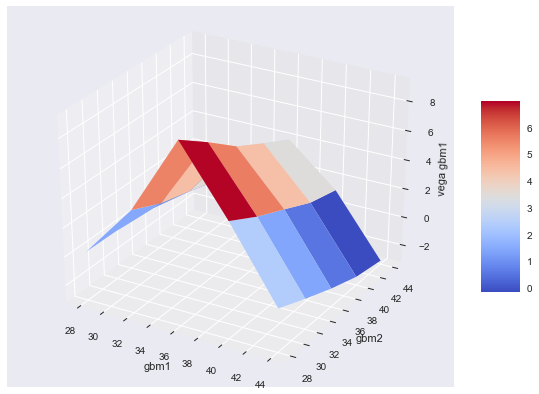

In [52]:
plot_greeks_3d([a_1, a_2, vega_1], ['gbm1', 'gbm2', 'vega gbm1'])

And the one for the second **risk factor**.

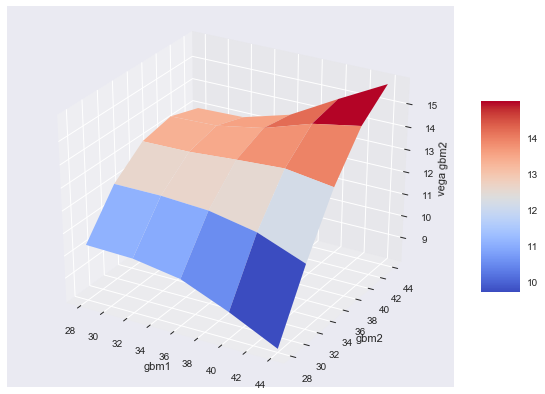

In [53]:
plot_greeks_3d([a_1, a_2, vega_2], ['gbm1', 'gbm2', 'vega gbm2'])

Finally, we reset the intial values and the volatilities for the two risk factors.

In [54]:
# restore initial values
vc.update('gbm1', initial_value=36., volatility=0.1)
vc.update('gbm2', initial_value=36., volatility=0.5)

## valuation_mcs_american_multi

In general, the modeling and handling of the valuation classes for American exercise is not too different from those for European exercise. The **major difference** is in the definition of payoff function.

### Present Values

This example models an **American minimum put** on the two risk factors from before.

In [55]:
# American put payoff
payoff_am = "np.maximum(34 - np.minimum(instrument_values['gbm1'], instrument_values['gbm2']), 0)"
# finer time grid and more paths
val_env.add_constant('frequency', 'B')
val_env.add_curve('time_grid', None)
  # delete existing time grid information
val_env.add_constant('paths', 5000)

In [56]:
# American put option on minimum of two assets
vca = valuation_mcs_american_multi(
            name='American minimum put',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff_am)

In [57]:
vca.present_value()

4.607

In [58]:
matrix={'gbm1': np.array([ 33.8899222 ,  39.25932511]),
        'gbm1gbm1': np.array([ 1148.52682654,  1541.29460798])}

In [59]:
matrix

{'gbm1': array([33.8899222 , 39.25932511]),
 'gbm1gbm1': array([1148.52682654, 1541.29460798])}

In [60]:
np.array(list(matrix.values())).T

array([[  33.8899222 , 1148.52682654],
       [  39.25932511, 1541.29460798]])

In [61]:
for key, obj in vca.instrument_values.items():
    print(np.shape(vca.instrument_values[key]))

(261, 5000)
(261, 5000)


The **present value surface** is generated in the same way as before for the European option on the two risk factors. The computational burden is of course much higher for the American option, which are valued by the use of the **Least-Squares Monte Carlo approach (LSM)** according to Longstaff-Schwartz (2001).

In [62]:
asset_1 = np.arange(28., 44.1, 4.)
asset_2 = asset_1
a_1, a_2 = np.meshgrid(asset_1, asset_2)
value = np.zeros_like(a_1)

In [63]:
%%time
for i in range(np.shape(value)[0]):
    for j in range(np.shape(value)[1]):
        vca.update('gbm1', initial_value=a_1[i, j])
        vca.update('gbm2', initial_value=a_2[i, j])
        value[i, j] = vca.present_value()

CPU times: user 4.41 s, sys: 202 ms, total: 4.61 s
Wall time: 4.62 s


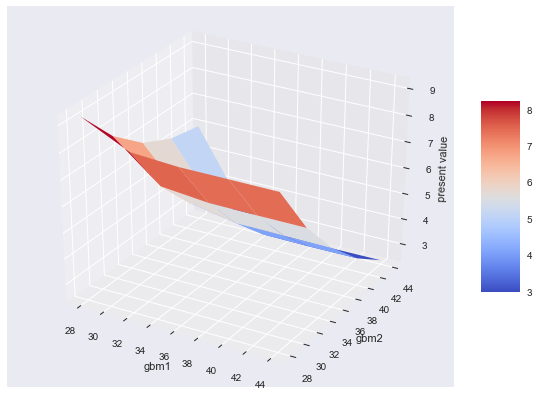

In [64]:
plot_greeks_3d([a_1, a_2, value], ['gbm1', 'gbm2', 'present value'])

### Delta Surfaces

The same exercise as before for the two **delta surfaces**.

In [65]:
delta_1 = np.zeros_like(a_1)
delta_2 = np.zeros_like(a_1)

In [66]:
%%time
for i in range(np.shape(delta_1)[0]):
    for j in range(np.shape(delta_1)[1]):
        vca.update('gbm1', initial_value=a_1[i, j])
        vca.update('gbm2', initial_value=a_2[i, j])
        delta_1[i, j] = vca.delta('gbm1')
        delta_2[i, j] = vca.delta('gbm2')

CPU times: user 16.7 s, sys: 730 ms, total: 17.4 s
Wall time: 17.4 s


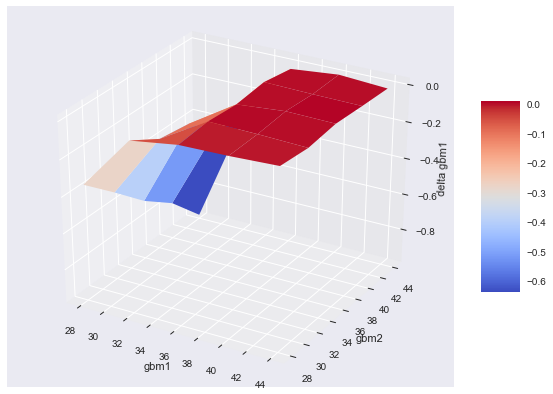

In [67]:
plot_greeks_3d([a_1, a_2, delta_1], ['gbm1', 'gbm2', 'delta gbm1'])

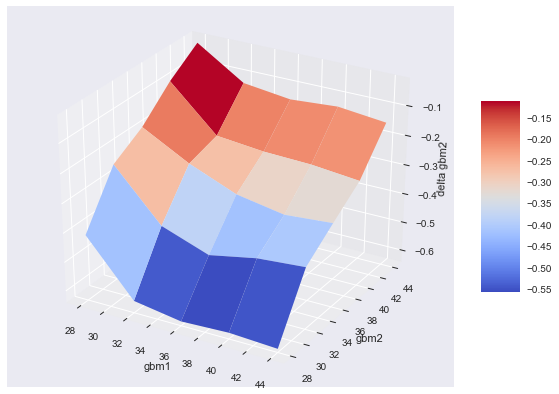

In [68]:
plot_greeks_3d([a_1, a_2, delta_2], ['gbm1', 'gbm2', 'delta gbm2'])

### Vega Surfaces

And finally for the **vega surfaces**.

In [69]:
vega_1 = np.zeros_like(a_1)
vega_2 = np.zeros_like(a_1)

In [70]:
%%time
for i in range(np.shape(vega_1)[0]):
    for j in range(np.shape(vega_1)[1]):
        vca.update('gbm1', initial_value=a_1[i, j])
        vca.update('gbm2', initial_value=a_2[i, j])
        vega_1[i, j] = vca.vega('gbm1')
        vega_2[i, j] = vca.vega('gbm2')

CPU times: user 17.5 s, sys: 747 ms, total: 18.3 s
Wall time: 18.4 s


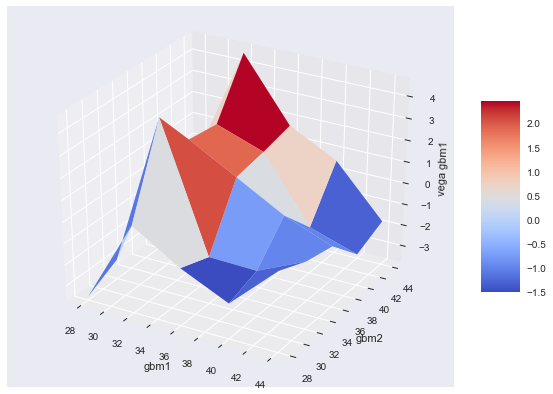

In [71]:
plot_greeks_3d([a_1, a_2, vega_1], ['gbm1', 'gbm2', 'vega gbm1'])

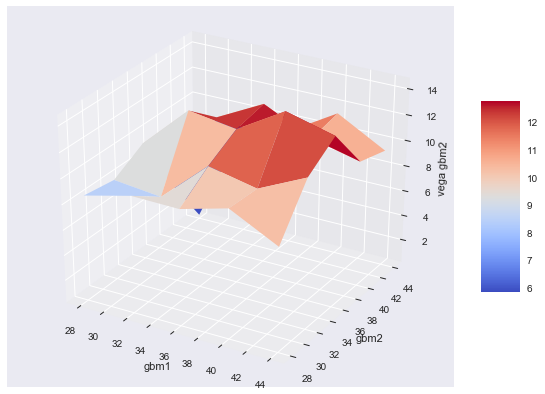

In [72]:
plot_greeks_3d([a_1, a_2, vega_2], ['gbm1', 'gbm2', 'vega gbm2'])

## More than Two Risk Factors

The principles of working with multi-risk valuation classes can be illustrated quite well in the two risk factor case. However, there is---in theory---**no limitation on the number of risk factors** used for derivatives modeling.

### Four Asset Basket Option

Consider a **maximum basket option** on four different risk factors. We add a **jump diffusion** as well as a **stochastic volatility** model to the mix

In [73]:
me3 = market_environment('me3', dt.datetime(2015, 1, 1))
me4 = market_environment('me4', dt.datetime(2015, 1, 1))

In [74]:
me3.add_environment(me1)
me4.add_environment(me1)

In [75]:
# for jump-diffusion
me3.add_constant('lambda', 0.5)
me3.add_constant('mu', -0.6)
me3.add_constant('delta', 0.1)
me3.add_constant('model', 'jd')

In [76]:
# for stoch volatility model
me4.add_constant('kappa', 2.0)
me4.add_constant('theta', 0.3)
me4.add_constant('vol_vol', 0.2)
me4.add_constant('rho', -0.75)
me4.add_constant('model', 'sv')

In [77]:
val_env.add_constant('paths', 10000)
val_env.add_constant('frequency', 'W')
val_env.add_curve('time_grid', None)

In this case, we need to specify **three correlation** values.

In [78]:
risk_factors = {'gbm1' : me1, 'gbm2' : me2, 'jd' : me3, 'sv' : me4}
correlations = [['gbm1', 'gbm2', 0.5], ['gbm2', 'jd', -0.5], ['gbm1', 'sv', 0.7]]

The **payoff function** in this case gets a bit more complex.

In [79]:
# European maximum call payoff
payoff_1 = "np.maximum(np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']),"
payoff_2 = " np.maximum(maturity_value['jd'], maturity_value['sv'])) - 40, 0)"
payoff = payoff_1 + payoff_2

In [80]:
payoff

"np.maximum(np.maximum(np.maximum(maturity_value['gbm1'], maturity_value['gbm2']), np.maximum(maturity_value['jd'], maturity_value['sv'])) - 40, 0)"

However, the instantiation of the valuation classe remains the same.

In [81]:
vc = valuation_mcs_european_multi(
            name='European maximum call',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff)

### Example Output and Calculations

The following just displays some example output and the results from certain calculations.

In [82]:
vc.risk_factors

{'gbm1': <dx.frame.market_environment at 0x114a74978>,
 'gbm2': <dx.frame.market_environment at 0x114a74940>,
 'jd': <dx.frame.market_environment at 0x115ae88d0>,
 'sv': <dx.frame.market_environment at 0x115ae81d0>}

In [83]:
vc.underlying_objects

{'gbm1': <dx.models.geometric_brownian_motion.geometric_brownian_motion at 0x115ae8a58>,
 'gbm2': <dx.models.geometric_brownian_motion.geometric_brownian_motion at 0x116613710>,
 'jd': <dx.models.jump_diffusion.jump_diffusion at 0x1166131d0>,
 'sv': <dx.models.stochastic_volatility.stochastic_volatility at 0x1166139b0>}

In [84]:
vc.present_value()

13.197

The **correlation and Cholesky matrices** now are of shape 4x4.

In [85]:
vc.correlation_matrix

,gbm1,gbm2,jd,sv
gbm1,1.0,0.5,0.0,0.7
gbm2,0.5,1.0,-0.5,0.0
jd,0.0,-0.5,1.0,0.0
sv,0.7,0.0,0.0,1.0


In [86]:
vc.val_env.get_list('cholesky_matrix')

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.8660254 ,  0.        ,  0.        ],
       [ 0.        , -0.57735027,  0.81649658,  0.        ],
       [ 0.7       , -0.40414519, -0.2857738 ,  0.51478151]])

**Delta and vega estimates** are generated in exactly the same fashion as in the two risk factor case.

In [87]:
vc.delta('jd', interval=0.1)

0.4549

In [88]:
vc.delta('sv')

0.3782

In [89]:
vc.vega('jd')

5.8494

In [90]:
vc.vega('sv')

1.199

### Delta for Jump Diffusion and Stochastic Vol Process

Of course, we cannot visualize **Greek surfaces** dependent on initial values for all four risk factors but still for two. In what follows we generate the **delta surfaces** with respect to the jump diffusion- and stochastic volatility-based risk factors.

In [91]:
delta_1 = np.zeros_like(a_1)
delta_2 = np.zeros_like(a_1)

In [92]:
%%time
for i in range(np.shape(delta_1)[0]):
    for j in range(np.shape(delta_1)[1]):
        vc.update('jd', initial_value=a_1[i, j])
        vc.update('sv', initial_value=a_2[i, j])
        delta_1[i, j] = vc.delta('jd')
        delta_2[i, j] = vc.delta('sv')

CPU times: user 8.28 s, sys: 820 ms, total: 9.1 s
Wall time: 8.44 s


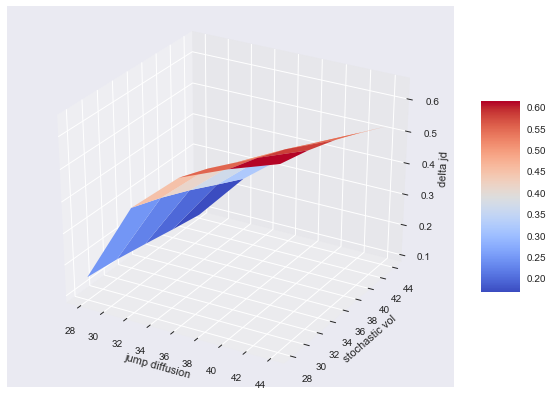

In [93]:
plot_greeks_3d([a_1, a_2, delta_1], ['jump diffusion', 'stochastic vol', 'delta jd'])

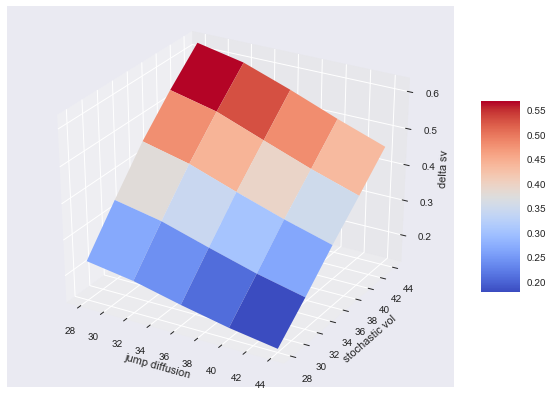

In [94]:
plot_greeks_3d([a_1, a_2, delta_2], ['jump diffusion', 'stochastic vol', 'delta sv'])

### Vega for Jump Diffusion and Stochastic Vol Process

Now the same exercise for the **vega surfaces** for the same two risk factors.

In [95]:
vega_1 = np.zeros_like(a_1)
vega_2 = np.zeros_like(a_1)

In [96]:
%%time
for i in range(np.shape(vega_1)[0]):
    for j in range(np.shape(vega_1)[1]):
        vc.update('jd', initial_value=a_1[i, j])
        vc.update('sv', initial_value=a_2[i, j])
        vega_1[i, j] = vc.vega('jd')
        vega_2[i, j] = vc.vega('sv')

CPU times: user 7.82 s, sys: 710 ms, total: 8.53 s
Wall time: 7.97 s


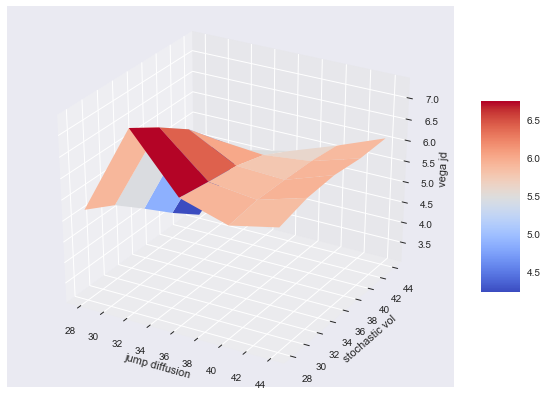

In [97]:
plot_greeks_3d([a_1, a_2, vega_1], ['jump diffusion', 'stochastic vol', 'vega jd'])

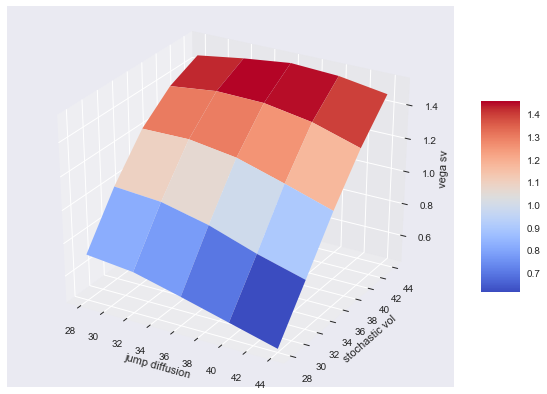

In [98]:
plot_greeks_3d([a_1, a_2, vega_2], ['jump diffusion', 'stochastic vol', 'vega sv'])

### American Exercise

As a final illustration consider the case of an **American minimum put option** on the four risk factors. This again is a step that leads to a much increased computational burden due to the necessity to apply the least-squares regression approach.

In [99]:
# payoff of American minimum put option
payoff_am_1 = "np.maximum(40 - np.minimum(np.minimum(instrument_values['gbm1'], instrument_values['gbm2']),"
payoff_am_2 = "np.minimum(instrument_values['jd'], instrument_values['sv'])), 0)"
payoff_am = payoff_am_1 + payoff_am_2

In [100]:
vca = valuation_mcs_american_multi(
            name='American minimum put',
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            payoff_func=payoff_am)

However, another illustration that even such a complex instrument can be handled as elegantly as the most simple one (i.e. European option on single risk factor). Let us compare the **present value estimates** for both the European and American maximum basket options. 

In [101]:
# restore initial values
vc.update('jd', initial_value=36., volatility=0.1)
vc.update('sv', initial_value=36., volatility=0.1)
%time vc.present_value()

CPU times: user 3.78 ms, sys: 24 µs, total: 3.81 ms
Wall time: 3.84 ms


13.197

In [102]:
%time vca.present_value()

CPU times: user 335 ms, sys: 39.7 ms, total: 375 ms
Wall time: 321 ms


14.301

In [103]:
%time vca.delta('gbm1')

CPU times: user 439 ms, sys: 48.3 ms, total: 487 ms
Wall time: 401 ms


-0.0034

In [104]:
%time vca.delta('gbm2')

CPU times: user 491 ms, sys: 59.4 ms, total: 550 ms
Wall time: 452 ms


-0.2115

In [105]:
%time vca.vega('jd')

CPU times: user 514 ms, sys: 55.1 ms, total: 569 ms
Wall time: 475 ms


1.994

In [106]:
%time vca.vega('sv')

CPU times: user 546 ms, sys: 56.1 ms, total: 602 ms
Wall time: 509 ms


0.5641

In [107]:
print('Duration for notebook execution %.2f in min' % ((time.time() - t0) / 60))

Duration for notebook execution 1.19 in min


**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)